# Prerequisites

In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import py_pcha
from IPython.display import display
from minisom import MiniSom
from scipy.signal import find_peaks
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

# Load data

In [2]:
df = pd.read_pickle("data/data_df.pkl")

In [3]:
df.head()

,BVP,EDA,HR,TEMP,response,round,phase,participant,BVP_synched,EDA_synched,HR_synched,TEMP_synched
0,BVP time time_...,EDA time time_s...,HR time time_seconds 0...,TEMP time time_seco...,particpant_ID puzzler team_ID E4_nr up...,round_1,phase1,"(D1_1, ID_1)","[-61.33, -56.25, -47.83, -35.69, -20.53, -4.1,...","[0.18582699999999977, 0.1829076670776679, 0.18...","[76.75, 76.727209151694, 76.70528827982247, 76...","[30.970000000000002, 30.94919405798327, 30.931..."
1,BVP time time...,EDA time time_s...,HR time time_seconds 0...,TEMP time time_seco...,particpant_ID puzzler team_ID E4_nr up...,round_1,phase2,"(D1_1, ID_1)","[-3.4, -12.83, -15.64, -14.6, -13.47, -15.57, ...","[0.37293500000000007, 0.3721420514550866, 0.37...","[99.05000000000001, 99.13276287762805, 99.2123...","[32.25, 32.22400479580902, 32.20217554746913, ..."
2,BVP time time_...,EDA time time_s...,HR time time_seconds 0...,TEMP time time_seco...,particpant_ID puzzler team_ID E4_nr up...,round_1,phase3,"(D1_1, ID_1)","[-9.1, 6.31, 16.96, 24.92, 33.21, 44.33, 59.3,...","[0.4395760000000001, 0.4465668533347507, 0.452...","[84.41999999999997, 84.39629188721365, 84.3734...","[32.97000000000001, 32.96410203604903, 32.9590..."
3,BVP time time...,EDA time time_s...,HR time time_seconds 0...,TEMP time time_seco...,particpant_ID puzzler team_ID E4_nr up...,round_2,phase1,"(D1_1, ID_1)","[-110.39, -93.89, -78.44, -66.28, -57.98, -52....","[0.4946829999999997, 0.49578687423329, 0.49674...","[76.33000000000006, 76.2876193259277, 76.24702...","[33.37, 33.358575048481086, 33.3490854286391, ..."
4,BVP time time_...,EDA time time_s...,HR time time_seconds 0...,TEMP time time_seco...,particpant_ID puzzler team_ID E4_nr up...,round_2,phase2,"(D1_1, ID_1)","[38.31, 44.5, 50.35, 55.65, 60.11, 63.63, 66.4...","[0.3911439999999993, 0.39106217928641135, 0.39...","[83.53000000000003, 83.51060349067826, 83.4920...","[33.709999999999965, 33.6961202327857, 33.6845..."


# Raw time series features

In [4]:
measurements = ['BVP', 'EDA', 'HR', 'TEMP']
X = np.array([
    np.concatenate([df.loc[row, f'{m}_synched']
                    for m in measurements])
    for row in range(df.shape[0])
])
X.shape, X.size

((312, 76800), 23961600)

In [5]:
# Downscale!
# Uncomment later
X = X[:, np.arange(0, X.shape[1], 32)]
X.shape, X.size

((312, 2400), 748800)

# Feature extraction

In [7]:
def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [8]:
X = []
order = 5
fs = 64
for row in range(df.shape[0]):
    features = []

    for m in ('EDA', 'HR', 'TEMP'):
        # Linear regression with quadratic term.
        y = df.loc[row, f'{m}_synched']
        X_m = np.arange(y.size)
        X_m = np.vstack([X_m**i for i in range(1, order + 1)])
        # Linear model with 2nd order trends
        reg = LinearRegression().fit(X_m.T, y)
        betas = np.append(reg.coef_, reg.intercept_)
        features.append(betas)
    for m in ('BVP',):
        # Compute DFT
        m_dft = np.abs(np.fft.rfft(df.loc[row, f'{m}_synched']))[:2000]  # DFT
        # features.append(m_dft)
        features.append(moving_average(m_dft, 20))

        # plt.plot(m_dft)
        # plt.show()
        # plt.plot(moving_average(m_dft, 20))
        # plt.show()
        # peaks, properties = find_peaks(m_dft, distance=20)
        # plt.plot(m_dft)
        # plt.scatter(peaks, m_dft[peaks], c='r')
        # plt.show()
    X.append(np.concatenate(features))

X = np.array(X)
X.shape

(312, 1999)

In [9]:
# n_features = X.shape[1]
# fig, ax = plt.subplots(n_features, n_features, figsize=(12, 8), tight_layout=True)
# for i in range(n_features):
#     for j in range(n_features):
#         ax[i,j].scatter(X[:,i], X[:,j], marker = '.')
# plt.show()

In [10]:
# Normalize
X -= X.mean(0)
X /= X.std(0)

# Apply method

In [11]:
n_components = 9
model = decomposition.PCA(n_components=n_components)
X_train_transformed = model.fit_transform(X)
X_hat = X_train_transformed.dot(model.components_) + model.mean_
L = 0.5 * np.linalg.norm(X - X_hat)**2
components = model.components_

In [12]:
XC, S, C, SSE, varexpl = py_pcha.PCHA(X, noc=n_components, delta=0.1)

X_hat = X @ C @ S
L = 0.5 * np.linalg.norm(X - X_hat)**2

# X_plot = np.asarray(np.concatenate((XC, XC[:,0]),axis=1))
X_plot = np.asarray(XC)

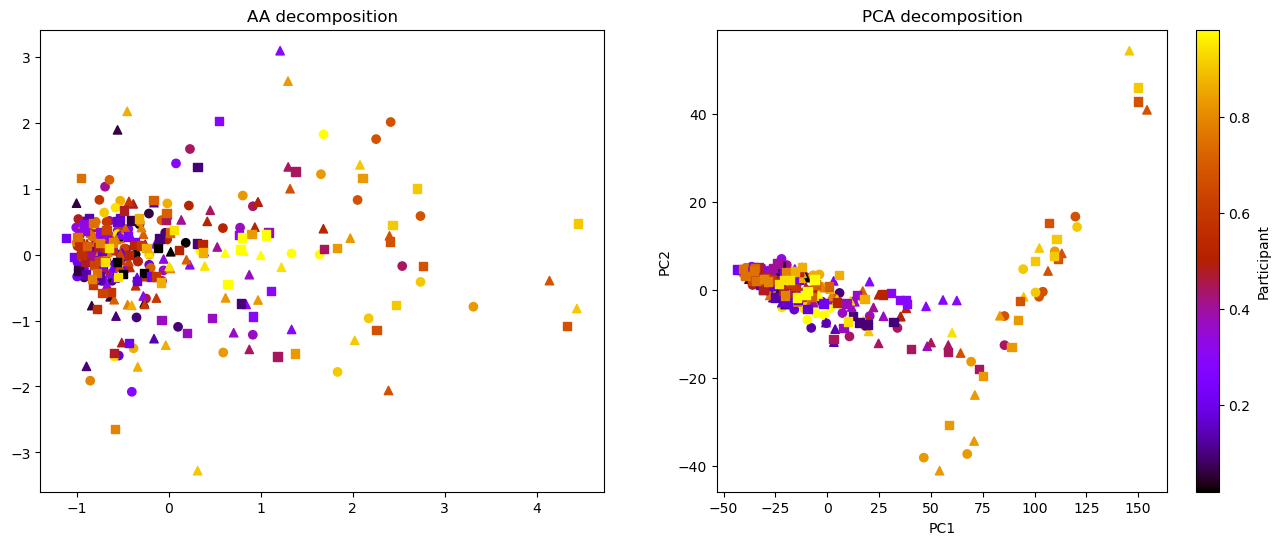

In [13]:
cm = 'gnuplot'

colours = (np.arange(0, 26) + .5) / 26
participant_to_colour = {
    participant: colour
    for participant, colour in zip(df.loc[:, 'participant'].unique(), colours)
}
c = np.array(
    list(map(lambda x: participant_to_colour[x], df.loc[:, 'participant'])))
markers = "o^s"
phase_to_marker = {
    phase: marker for phase, marker in zip(df.loc[:, 'phase'].unique(), markers)
}

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)
for phase in df.loc[:, 'phase'].unique():
    mask = df.loc[:, 'phase'] == phase
    marker = phase_to_marker[phase]
    ax.set_title('AA decomposition')
    sc = ax.scatter(X_plot[mask, 0],
                    X_plot[mask, 1],
                    c=c[mask],
                    marker=marker,
                    cmap=cm)  #,'k-', linewidth=2)
    # cbar = plt.colorbar(sc)
    # cbar.set_label('Person ID')

    ax1.set_title('PCA decomposition')
    sc = ax1.scatter(X_train_transformed[mask, 0],
                     X_train_transformed[mask, 1],
                     c=c[mask],
                     marker=marker,
                     cmap=cm)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
cbar = plt.colorbar(sc)
cbar.set_label('Participant')

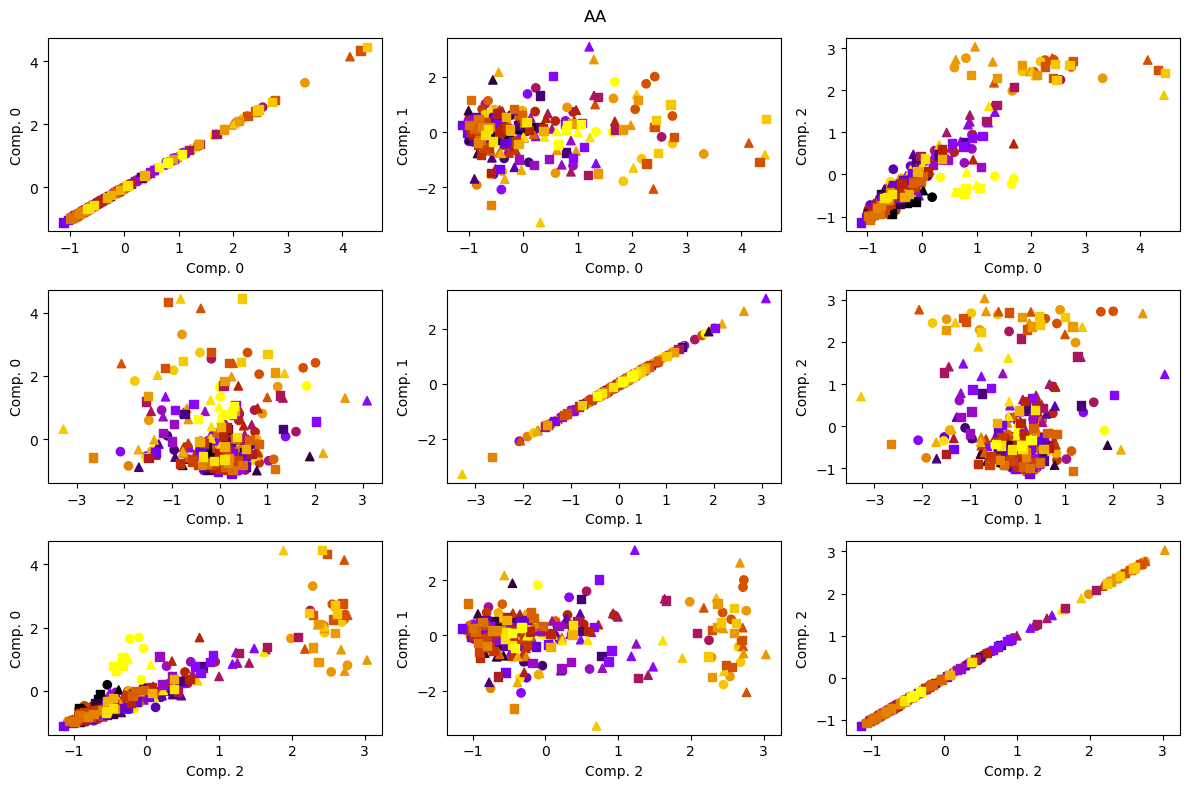

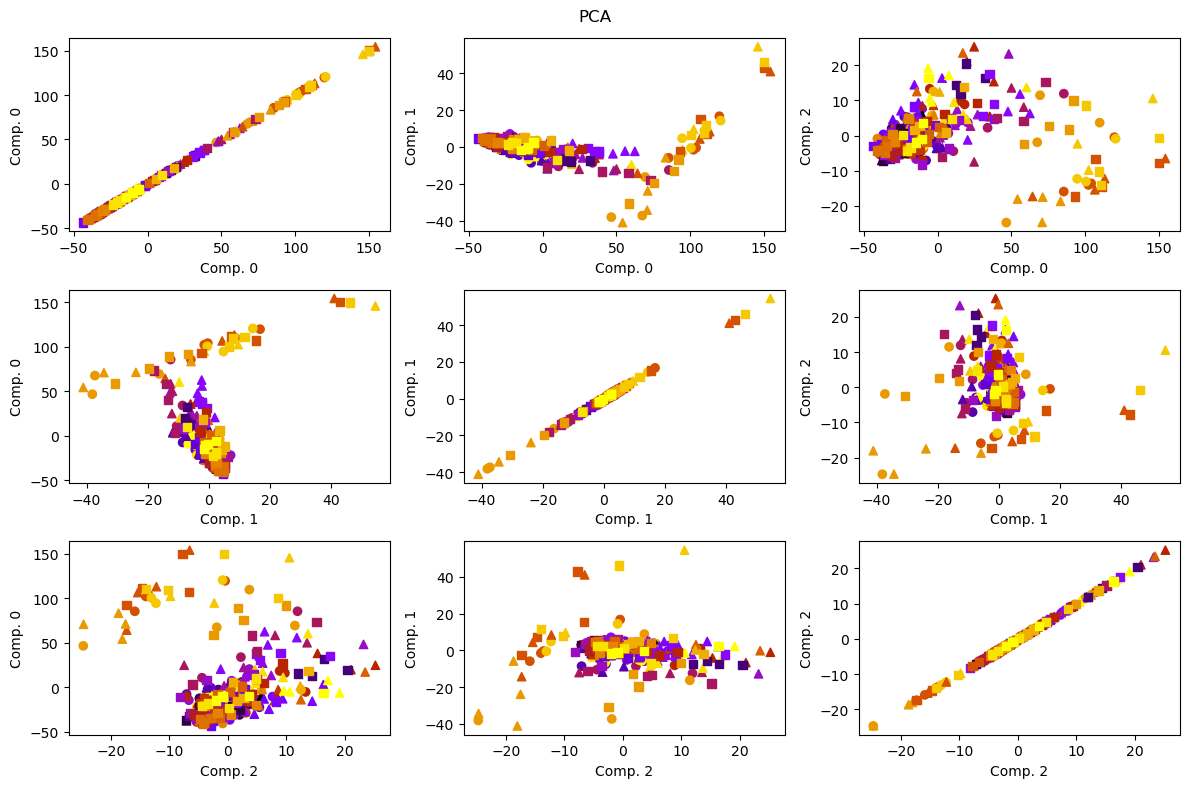

In [20]:
n_show = 3
fig, ax = plt.subplots(n_show,
                       n_show,
                       figsize=(12, 8),
                       tight_layout=True)
fig.suptitle('AA')
for phase in df.loc[:, 'phase'].unique():
    mask = df.loc[:, 'phase'] == phase
    marker = phase_to_marker[phase]
    for i in range(n_show):
        for j in range(n_show):
            ax[i, j].scatter(X_plot[mask, i],
                             X_plot[mask, j],
                             c=c[mask],
                             marker=marker,
                             cmap=cm)
            ax[i, j].set_xlabel(f'Comp. {i}')
            ax[i, j].set_ylabel(f'Comp. {j}')
plt.show()

fig, ax = plt.subplots(n_show,
                       n_show,
                       figsize=(12, 8),
                       tight_layout=True)
fig.suptitle('PCA')
for phase in df.loc[:, 'phase'].unique():
    mask = df.loc[:, 'phase'] == phase
    marker = phase_to_marker[phase]
    for i in range(n_show):
        for j in range(n_show):
            ax[i, j].scatter(X_train_transformed[mask, i],
                             X_train_transformed[mask, j],
                             c=c[mask],
                             marker=marker,
                             cmap=cm)
            ax[i, j].set_xlabel(f'Comp. {i}')
            ax[i, j].set_ylabel(f'Comp. {j}')
plt.show()

 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 1.475984528886678


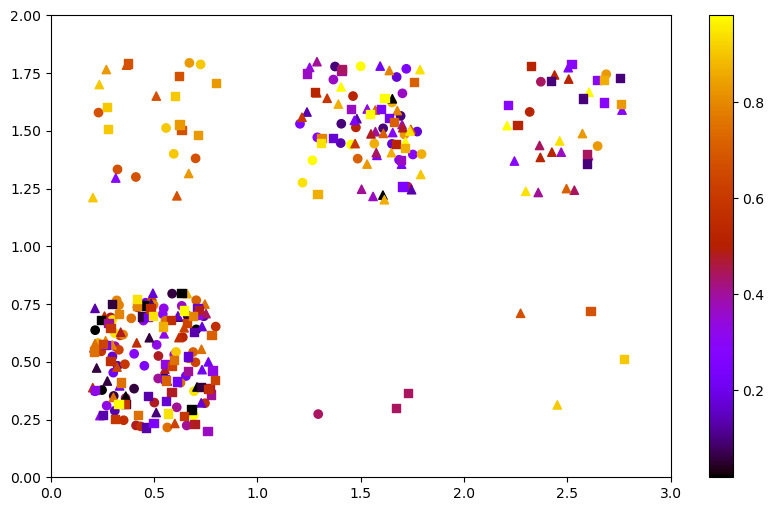

In [15]:
X_som = X_plot
n_components_som = X_som.shape[1]
som_shape = (3, 2)
# som_shape = (2, 2)

som = MiniSom(som_shape[0],
              som_shape[1],
              n_components_som,
              sigma=0.1,
              learning_rate=0.5)

som.pca_weights_init(X_som)
som.train_batch(X_som, int(5e4), verbose=True)

plt.figure(figsize=(10, 6))
y = df.loc[:, 'participant']
_, y = np.unique(y, return_inverse=True)
for phase in df.loc[:, 'phase'].unique():
    mask = df.loc[:, 'phase'] == phase
    marker = phase_to_marker[phase]
    xvals, yvals = [], []
    for x, t in zip(X_som[mask, :], y[mask]):  # scatterplot
        w = som.winner(x)
        xval = w[0] + .5 + 0.6 * np.random.rand(1) - 0.3
        yval = w[1] + .5 + 0.6 * np.random.rand(1) - 0.3
        xvals.append(xval)
        yvals.append(yval)
    plt.scatter(xvals, yvals, c=c[mask], marker=marker, cmap=cm)

plt.axis([0, som.get_weights().shape[0], 0, som.get_weights().shape[1]])
plt.colorbar()
plt.savefig('figs/clusters.png', dpi=200)
plt.show()

- find cluster center, find alle de personer / trials der tilhører den cluster

- for den cluster tag deres mean response og visualiser som et radar plot

In [16]:
centroids = som.get_weights()

# y = np.arange(n_components)
assigned_centroid = defaultdict(list)
for i, (x, t) in enumerate(zip(X_som, y)):
    w = som.winner(x)
    xval = w[0]
    yval = w[1]
    assigned_centroid[(xval, yval)].append(i)

# assigned_centroid

they are numbered as x, y from the lower left

In [83]:
responses = pd.DataFrame()
for cluster, idx in assigned_centroid.items():
    responses_cluster = pd.concat([df.loc[i, 'response'].T[5:].T for i in idx],
                                axis=0)
    phases_cluster = [df.loc[i, 'phase'] for i in idx]
    responses_cluster['phase'] = phases_cluster
    responses_cluster['cluster'] = [cluster] * len(idx)
    # mean over the response per cluster per phase
    responses = pd.concat([responses, responses_cluster], axis=0)
responses = responses.groupby(['phase', 'cluster']).mean()
idx = pd.MultiIndex.from_tuples(responses.index)
responses = responses.reindex(idx, fill_value=0)
responses.reset_index(inplace=True)
responses = responses.rename(columns={"level_0": "phase", "level_1": "cluster"})
# Rescale frustrated and difficulty
responses.loc[:, ('frustrated', 'difficulty')] /= 2
responses.head()

,phase,cluster,hostile,alert,ashamed,inspired,nervous,determined,attentive,afraid,active,frustrated,difficulty
0,phase1,"(0, 0)",1.015625,2.000000,1.031250,1.984375,1.468750,2.841270,2.634921,1.063492,2.238095,0.500000,0.0
1,phase1,"(0, 1)",1.000000,2.750000,1.000000,2.250000,1.125000,3.250000,3.125000,1.000000,2.875000,0.562500,0.0
2,phase1,"(1, 0)",1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,NaN
3,phase1,"(1, 1)",1.074074,1.703704,1.259259,2.000000,1.555556,2.407407,2.407407,1.148148,1.814815,0.648148,0.0
4,phase1,"(2, 1)",1.000000,2.500000,1.000000,3.250000,1.250000,4.250000,3.000000,1.000000,2.750000,0.375000,0.0


In [84]:
# Sentiment from ChatGPT
scores = {
    "hostile": -4,
    "alert": 2,
    "ashamed": -3,
    "inspired": 4,
    "nervous": -2,
    "determined": 4,
    "attentive": 3,
    "afraid": -3,
    "active": 3,
    "frustrated": -2,
}
sorted_emotions = list(dict(sorted(scores.items(), key=lambda item: item[1], reverse=True)))
sorted_emotions.append('difficulty')
sorted_emotions

['inspired',
 'determined',
 'attentive',
 'active',
 'alert',
 'nervous',
 'frustrated',
 'ashamed',
 'afraid',
 'hostile',
 'difficulty']

In [86]:
responses = responses[['phase', 'cluster'] + sorted_emotions]

## One radar plot for each phase

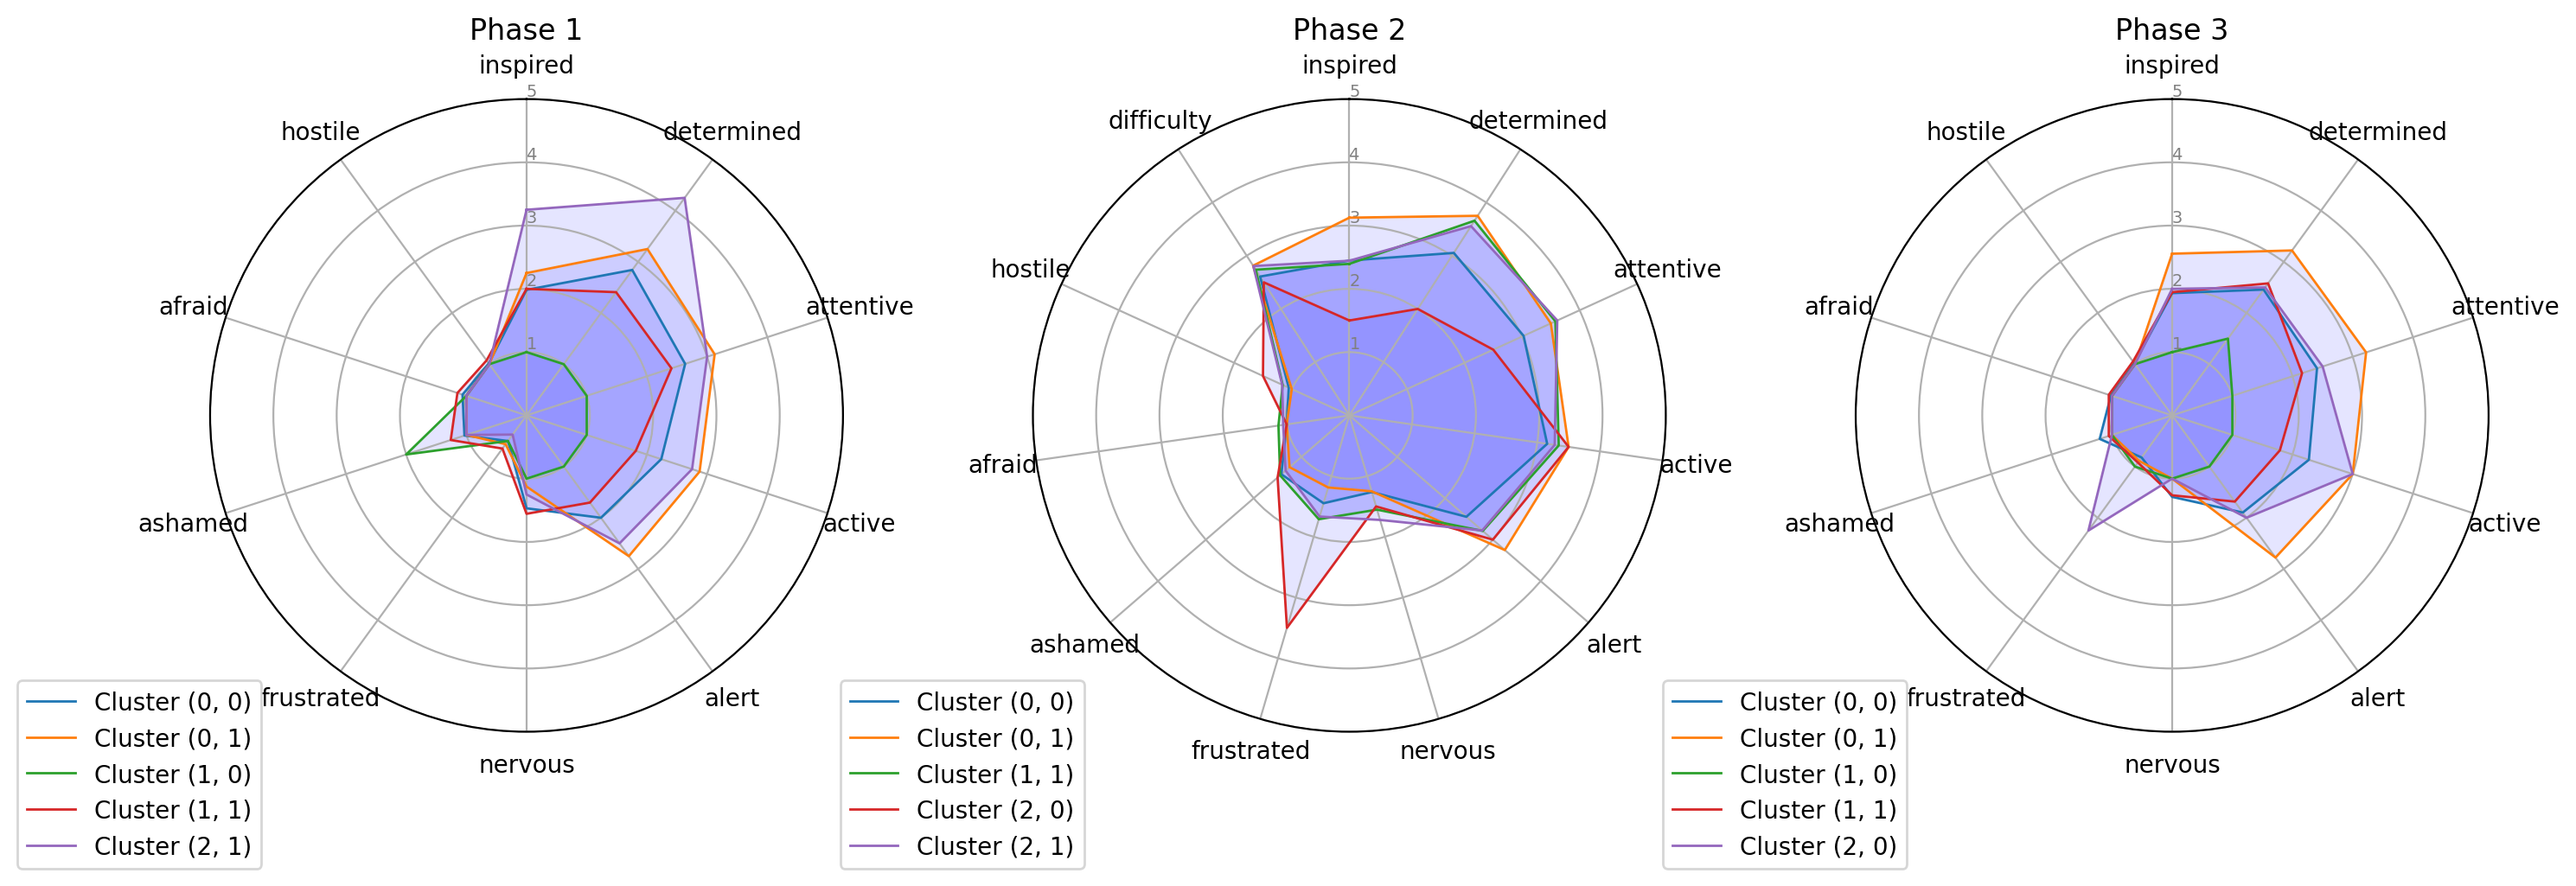

In [92]:
# https://www.python-graph-gallery.com/391-radar-chart-with-several-individuals


# Initialise the spider plot
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'},dpi=200, figsize=(17,5))
fig.subplots_adjust(wspace=0.3)
# If you want the first axis to be on top:
ranges = [(0,5), (5,10), (10,15)]
for j, ax in enumerate(axs):
    if j == 1:
        N = responses.shape[1]-2
        # Draw one axe per variable + add labels
        cols = responses.columns[2:]
    else:
        N = responses.shape[1]-3
        cols = responses.columns[2:-1]
        
    ax.set_yticks(list(range(1, 6)), ["1", "2", "3", "4", '5'], color="grey", size=7)
    ax.set_ylim(0, 5)
    # We need to repeat cthe first value to close the circular graph:

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    ax.set_xticks(angles[:-1], cols)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    # Draw ylabels
    ax.set_title(f'Phase {j+1}')
    ax.set_rlabel_position(0)
    
    for i in range(ranges[j][0], ranges[j][1]):
        if j == 1:
            response = responses.iloc[i, 2:]
        else:
            response = responses.iloc[i, 2:-1]
        # print(response)
        values = response.to_numpy()
        values = np.append(values, values[:1])
        ax.plot(angles,
                values,
                linewidth=1,
                linestyle='solid',
                label=f"Cluster {responses.iloc[i, 1]}")
        ax.fill(angles, values, 'b', alpha=0.1)

        # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.savefig('figs/emotions.png', dpi=200)
plt.show()

C:\Users\runes\AppData\Local\Temp\ipykernel_11272\3180436367.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  responses_all = responses.groupby(['cluster']).mean()


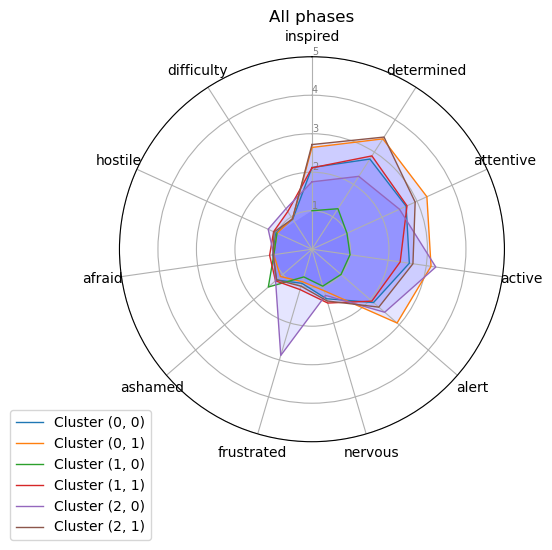

In [115]:
# https://www.python-graph-gallery.com/391-radar-chart-with-several-individuals
responses_all = responses.groupby(['cluster']).mean()
N = responses_all.shape[1]
cols = responses_all.columns

# Initialise the spider plot
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': 'polar'}, figsize=(5,5))
fig.subplots_adjust(wspace=0.3)
# If you want the first axis to be on top:


ax.set_yticks(list(range(1, 6)), ["1", "2", "3", "4", '5'], color="grey", size=7)
ax.set_ylim(0, 5)
# We need to repeat cthe first value to close the circular graph:

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]
ax.set_xticks(angles[:-1], cols)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw ylabels
ax.set_title(f'All phases')
ax.set_rlabel_position(0)

clusters = responses_all.index
for i in range(responses_all.shape[0]):
    response = responses_all.iloc[i, :]
    values = response.to_numpy()
    values = np.append(values, values[:1])
    ax.plot(angles,
            values,
            linewidth=1,
            linestyle='solid',
            label=f"Cluster {responses_all.index[i]}")
    ax.fill(angles, values, 'b', alpha=0.1)

    # Add legend
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.savefig('figs/emotions.png', dpi=200)
plt.show()